* 학습 코드를 실행하기 전에 <b>[런타임]</b> - <b>[런타임 유형 변경]</b>에서 하드웨어 가속기를 <b>[GPU]</b>로 설정한다.

### <b>데이터 세트 다운로드</b>

* 딥러닝 모델 학습 과정에서 필요한 데이터 세트를 불러온다.

In [ ]:
!git clone https://github.com/ndb796/weather_dataset
%cd weather_dataset

Cloning into 'weather_dataset'...
remote: Enumerating objects: 1117, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1117 (delta 0), reused 3 (delta 0), pack-reused 1111
Receiving objects: 100% (1117/1117), 85.23 MiB | 32.55 MiB/s, done.
/content/weather_dataset


### <b>라이브러리 불러오기(Load Libraries)</b>

* 딥러닝 모델 학습 과정에서 필요한 라이브러리를 불러온다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

### <b>데이터 세트 불러오기(Load Dataset)</b>

1. <b>데이터 증진(data augmentation)</b>을 명시하여 초기화할 수 있다.
  * 이미지를 불러올 때 어떤 방법(회전, 자르기, 뒤집기 등)을 사용할 것인지 명시한다.
2. 이후에 <b>DataLoader()</b>를 이용하여 실질적으로 데이터를 불러올 수 있다.
  * 어떤 데이터를 사용할 것인지, 배치 크기(batch size), 데이터 셔플(shuffle) 여부 등을 명시한다.
  * <b>next() 함수</b>를 이용하여 tensor 형태로 데이터를 배치 단위로 얻을 수 있다.
* <b>Reference</b>: https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),  #RandomHorizontalFlip을 통해 데이터 세트 크기를 증가시키고 다양한 데이터를 학습시켜 성능 향상 목적
    transforms.ToTensor(),              #Tensor 형태로 변경
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],           #이미지 데이터는 보통 RGB로 구성되어 있기 때문에 3개씩 작성
        std=[0.5, 0.5, 0.5]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [ ]:
#datasets.ImageFolder를 통해 데이터셋을 만듦
 #이때 root 를 통해 이미지 데이터가 저장된 루트 디렉토리를 지정함
train_dataset = datasets.ImageFolder(
    root='train/',
    transform=transform_train
)
dataset_size = len(train_dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(
    root='test/',
    transform=transform_test
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
#검증과 테스트는 성과만 확인하면 되기 때문에, shuffle = False
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

### <b>데이터 시각화(Data Visualization)</b>

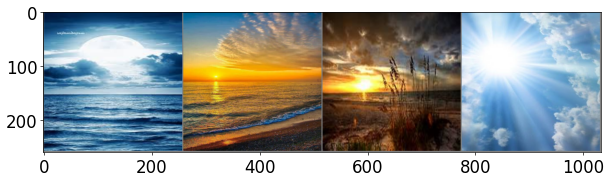

['Shine', 'Sunrise', 'Sunrise', 'Shine']


In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input):
    # torch.Tensor => numpy (plt와 같은 시각화와, 딥러닝 학습을 위해 numpy로 변경)
     #transpose 를 통해 형태 정렬 (높이, 너비, 채널) 순서
    input = input.numpy().transpose((1, 2, 0))

    # undo image normalization (역정규화)
     #학습할 때는 정규화를 진행하지만, 시각화를 할 때에는 역정규화 진행 (이미지를 원래의 범위로 돌리기 위해)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean

    #이미지의 데이터값 제한
     #0~1사이로
    input = np.clip(input, 0, 1)

    plt.imshow(input)
    plt.show()


class_names = {
  0: "Cloudy",
  1: "Rain",
  2: "Shine",
  3: "Sunrise"
}

# load a batch of train image
iterator = iter(train_dataloader)       #대용량 데이터를 효과적으로 처리하기 위해 이터럴 데이터로 변환

# visualize a batch of train image
imgs, labels = next(iterator)           #next() 를 통해 이미지와 labels를 가져오고 이를 대입시킴
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([class_names[labels[i].item()] for i in range(4)]) #tensor에서 스칼라값을 가져오기 위해 item() 활용

### <b>딥러닝 모델 학습(Training)</b>

* 자신이 직접 정의한 뉴럴 네트워크를 이용하여 데이터 세트에 대한 학습이 가능하다.
  * 레이어의 깊이를 늘려 가며, 파라미터의 개수를 증가시킬 수 있다.

In [ ]:
class Model1(nn.Module):                            #nn.Module을 상속받아서 Model1 구성
    def __init__(self):                             #self 매개변수를 통해 독립성 보장하면서 객체의 상태 관리
        super(Model1, self).__init__()              #부모 클래스 초기화
        self.linear1 = nn.Linear(256 * 256 * 3, 4) #nn.Linear(입력층, 출력층) 으로 구성됨, RGB이니까 3을 곱함
        self.flatten = nn.Flatten()

    def forward(self, x):                           #입력 데이터가 모델을 통과하여 예측값이 출력되는 '순전파'를 수행
        x = self.flatten(x)
        x = self.linear1(x)
        return x


class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.linear1 = nn.Linear(256*256*3, 64)
        self.linear2 = nn.Linear(64, 4)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)     #tensor 형태의 이미지를 평평하게 만듦
        x = self.linear1(x)
        x = self.linear2(x)
        return x


class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        self.linear1 = nn.Linear(256 * 256 * 3, 128)
        self.dropout1 = nn.Dropout(0.5)                  #정규화 기능 (뉴런을 50%의 확률로 무작위로 끔)
        self.linear2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.5)
        self.linear4 = nn.Linear(32, 4)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.linear1(x))                       #F.relu 활성화 함수로 비선형 인공망 신경 학습
        x = self.dropout1(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = F.relu(self.linear3(x))
        x = self.dropout3(x)
        x = self.linear4(x)
        return x

In [ ]:
import time


def train():
    start_time = time.time()            #학습 시간을 기록하기 위해 현재 시간 저장
    print(f'[Epoch: {epoch + 1} - Training]')       #epoch는 전체 데이터셋을 한 번 학습하는 것을 의미, epoch + 1은 1부터 시작하는 epoch 번호 의미
    model.train()       #위에서 dropout을 진행했기 때문에, 학습모델을 랜덤하게 설정하지 않도록 명확하게 제시??
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch            #batch에서 이미지 데이터와 라벨을 분리
        imgs, labels = imgs.cuda(), labels.cuda()   #이미지 데이터와 라벨을 GPU로 이동시켜 학습 가속화

        outputs = model(imgs)
        optimizer.zero_grad()                   #옵티마이저의 그라디언트를 0으로 초기화
        _, preds = torch.max(outputs, 1)        #outputs에서 예측값이 가장 큰 값과 해당 인덱스 구함
        loss = criterion(outputs, labels)       #예측값과 실제값을 통해 손실 계산

        loss.backward()                         #역전파를 통해 그라디언트 계산
        optimizer.step()                        #모델 파라미터 업데이트

        total += labels.shape[0]                #현재까지 처리한 샘플의 총 갯수 (누적)
        running_loss += loss.item()             #현재까지 처리한 손실의 총 갯수 (누적)
        running_corrects += torch.sum(preds == labels.data)     #정확하게 예측한 샘플의 갯수 누적

        if i % log_step == log_step - 1:        #미니 배치의 인덱스가 log_step -1 이 되면 출력
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():                       #valid는 grad를 지정할 필요가 없기 때문에 torch.no_grad() 실행
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [ ]:
import time

def adjust_learning_rate(optimizer, epoch):                 #epoch에 따라 학습률 조정
    lr = learning_rate
    if epoch >= 3:
        lr /= 10
    if epoch >= 7:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### <b>학습 결과 확인하기</b>

* 학습 결과를 시각화하여 정상적으로 모델이 학습되었는지 확인한다.

[Epoch: 1 - Training]
train loss: 0.3451758780302825, accuracy: 0.6014814972877502
elapsed time: 5.136876583099365
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.4961335361003876, running val accuracy: 0.65625
val loss: 0.6465789411194931, accuracy: 0.6568047404289246
elapsed time: 1.7391908168792725
[Info] best validation accuracy!
[Epoch: 2 - Training]
train loss: 0.4070393329196506, accuracy: 0.712592601776123
elapsed time: 5.872997760772705
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.3948057293891907, running val accuracy: 0.6875
val loss: 0.49458019550030047, accuracy: 0.6568047404289246
elapsed time: 1.7600014209747314
[Epoch: 3 - Training]
train loss: 0.2537422180175781, accuracy: 0.7333333492279053
elapsed time: 5.567091464996338
[Epoch: 3 - Validation]
[Batch: 1] running val loss: 0.4064549505710602, running val accuracy: 0.671875
val loss: 0.5741860090628178, accuracy: 0.6035503149032593
elapsed time: 1.8973357677459717
[Epoch: 4 - Training]
train loss: 0.1

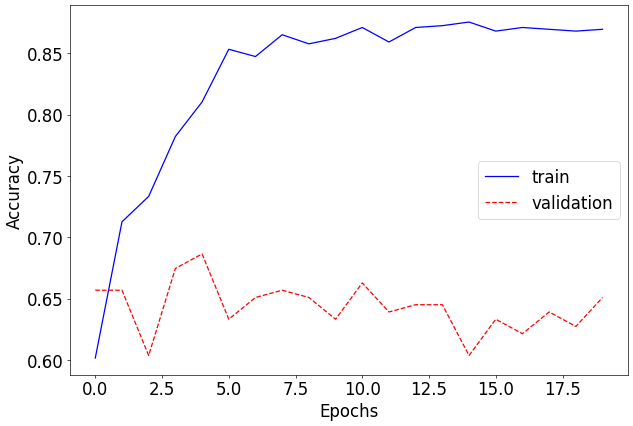

In [ ]:
learning_rate = 0.01
log_step = 20

model = Model1()
model = model.cuda()

criterion = nn.CrossEntropyLoss()               #분류 문제에서 널리 사용되는 손실함수 활용
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)       #SGD (확률적 경사하강법) 옵티마이저 생성

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:                  #best_val_acc: 가장 높은 검증 정확도를 기록하는 변수
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Epoch: 1 - Training]
train loss: 0.062059673556575067, accuracy: 0.5688889026641846
elapsed time: 7.238025426864624
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.10530433803796768, running val accuracy: 0.359375
val loss: 0.10420821263239934, accuracy: 0.4201183617115021
elapsed time: 1.2768044471740723
[Info] best validation accuracy!
[Epoch: 2 - Training]
train loss: 1.0577172201651115, accuracy: 0.4696296155452728
elapsed time: 7.619075536727905
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 2.3947598934173584, running val accuracy: 0.3125
val loss: 2.566202468420627, accuracy: 0.3136094808578491
elapsed time: 1.6057124137878418
[Epoch: 3 - Training]
train loss: 2.612469211154514, accuracy: 0.48444443941116333
elapsed time: 7.607187986373901
[Epoch: 3 - Validation]
[Batch: 1] running val loss: 1.6942405700683594, running val accuracy: 0.65625
val loss: 1.8532215998722956, accuracy: 0.6213017702102661
elapsed time: 1.323439121246338
[Info] best validation accuracy!
[E

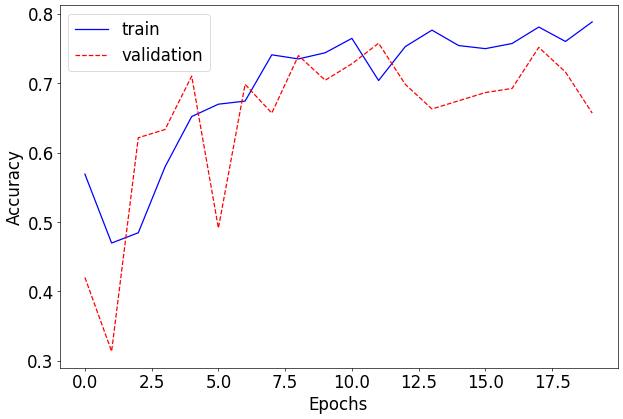

In [ ]:
learning_rate = 0.01
log_step = 20

model = Model2()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Epoch: 1 - Training]
train loss: 0.021055312863102665, accuracy: 0.3733333349227905
elapsed time: 7.819769620895386
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.014086698181927204, running val accuracy: 0.671875
val loss: 0.014450000588005111, accuracy: 0.6449704170227051
elapsed time: 1.6248998641967773
[Info] best validation accuracy!
[Epoch: 2 - Training]
train loss: 0.018197381849642154, accuracy: 0.5022222399711609
elapsed time: 7.623452186584473
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.012040120549499989, running val accuracy: 0.765625
val loss: 0.012633123694086921, accuracy: 0.7751479148864746
elapsed time: 1.3035023212432861
[Info] best validation accuracy!
[Epoch: 3 - Training]
train loss: 0.014740638291394268, accuracy: 0.6162962913513184
elapsed time: 7.739004373550415
[Epoch: 3 - Validation]
[Batch: 1] running val loss: 0.01066653709858656, running val accuracy: 0.75
val loss: 0.011399220080065303, accuracy: 0.7455621361732483
elapsed time: 1.28264

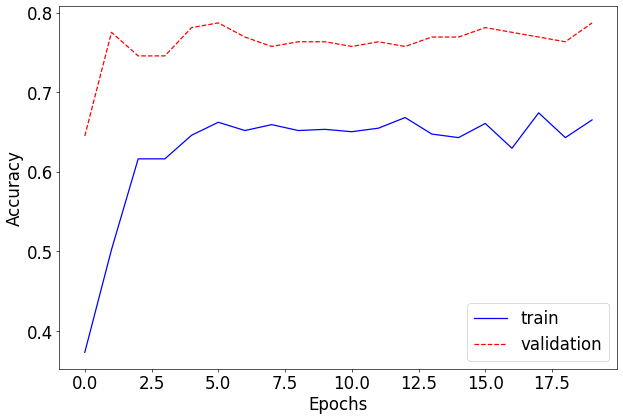

In [ ]:
learning_rate = 0.01
log_step = 20

model = Model3()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"best_checkpoint_epoch_{epoch + 1}.pth")

torch.save(model.state_dict(), f"last_checkpoint_epoch_{num_epochs}.pth")

plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")